In [1]:
from hyram.phys.wrapper.mass_flow_rate import wrapper

['TimeToEmpty:57.63709293027556',
 'MdotPlot:C:\\Users\\ehecht\\Documents\\PythonScripts\\Sandia-Made Packages\\hyram\\test\\image.png']

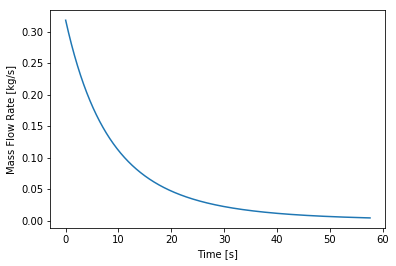

In [2]:
wrapper(T=293, P = 1.7237e7, TankVol = 0.2628, d_orifice = .25*.0254, Steady = False)

In [6]:
%load_ext autoreload
%autoreload 2
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

In [7]:
from scipy import optimize

In [8]:
def orifice_flow(self, T1 = None, P1 = None, rho1 = None, v1 = 0, P2 = 101325.):
    '''
    returns the flow through an orifice, for given upstream conditions

    Parameters
    ----------
    T - temperature (K)
    P - Pressure (Pa)
    rho - density (kg/m^3)
    user must specify 2 of three thermodynamic parameters of the stagnant gas

    Returns
    -------
    class containing T, P, rho, v at the throat (orifice)
    '''
    T1, P1, rho1 = self.T_P_rho(T1, P1, rho1)
    def err(Pthroat): 
        def err_choked(Tthroat):
            vthroat = self.a(Tthroat, Pthroat)
            return self._err_H(T1, P1, v1, Tthroat, Pthroat, vthroat)
        Tthroat = optimize.newton(err_choked, T1)
        return self._err_S(T1, P1, Tthroat, Pthroat)
    try:
        Pthroat = optimize.brenth(err, P1, P2)
        def err_choked(Tthroat):
            vthroat = self.a(Tthroat, Pthroat)
            return self._err_H(T1, P1, v1, Tthroat, Pthroat, vthroat)
        Tthroat = optimize.newton(err_choked, T1)
        vthroat = self.a(Tthroat, Pthroat)
    except:
        Pthroat = P2
        def err(vthroat):
            def err_choked(Tthroat):
                return self._err_H(T1, P1, v1, Tthroat, Pthroat, vthroat)
            Tthroat = optimize.newton(err_choked, T1)
            return self._err_S(T1, P1, Tthroat, Pthroat)
        vthroat =  optimize.newton(err, self.a(T1, Pthroat))
        def err_choked(Tthroat):
            return self._err_H(T1, P1, v1, Tthroat, Pthroat, vthroat)
        Tthroat = optimize.newton(err_choked, T1)

    class Result:
        pass
    throat = Result()
    throat.__dict__ = {'T': Tthroat, 'P': Pthroat, 'rho': self.rho(Tthroat, Pthroat), 'v': vthroat}
    return throat

In [9]:
from hyram.phys import *

In [10]:
H2 = Gas(AbelNoble(), T = 293, P = 700e5)
o = Orifice(d=1e-3)
tank = Source.fromMass(5, H2)

In [11]:
H2throat = o.flow(H2)
H2.__dict__, H2throat.__dict__

AttributeError: Orifice instance has no attribute 'flow'

In [12]:
%pylab inline

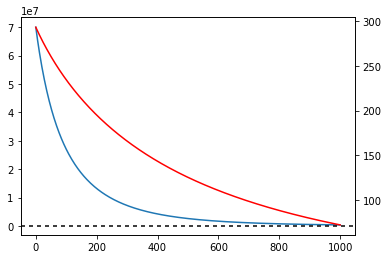

In [13]:
tank.gas = Gas(AbelNoble(), T = 293, P = 700e5)
tAN = np.linspace(0, 1000, 500)
mdotAN, gas_listAN = tank.blowdown(np.linspace(0, 1000, 500), o)
plt.plot(tAN, map(lambda g: g.P, gas_listAN));
plt.axhline(101325., color = 'k', dashes = (2,2));
plt.twinx()
plt.plot(tAN,map(lambda g: g.T, gas_listAN), 'r');

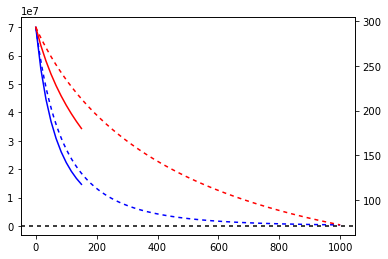

In [14]:
tank.gas = Gas(CoolProp(), T = 293, P = 700e5)
tCP = linspace(0, 150, 10)
mdotCP, gas_listCP = tank.blowdown(tCP, o)
plot(tAN, map(lambda g: g.P, gas_listAN), 'b', dashes = (2,2));
plot(tCP, map(lambda g: g.P, gas_listCP), 'b');
axhline(101325., color = 'k', dashes = (2,2));
twinx()
plot(tAN, map(lambda g: g.T, gas_listAN), 'r', dashes = (2,2));
plot(tCP, map(lambda g: g.T, gas_listCP), 'r');

In [15]:
from CoolProp.CoolProp import PropsSI

In [16]:
PropsSI(['U', 'H', 'D'], 'T', 293, 'P', 101325, 'nitrogen')

array([  2.16961730e+05,   3.03904028e+05,   1.16542812e+00])

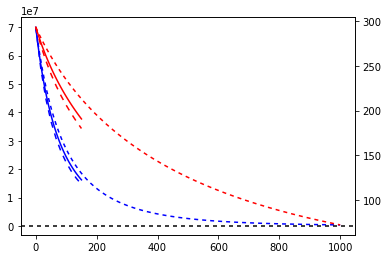

In [17]:
tank.gas = Gas(RefProp(), T = 293, P = 700e5)
tRP = linspace(0, 150, 100)
mdotRP, gas_listRP = tank.blowdown(tRP, o)
plot(tAN, map(lambda g: g.P, gas_listAN), 'b', dashes = (2,2));
plot(tCP, map(lambda g: g.P, gas_listCP), 'b', dashes = (3,3));
plot(tRP, map(lambda g: g.P, gas_listRP), 'b');
axhline(101325., color = 'k', dashes = (2,2));
twinx()
plot(tAN, map(lambda g: g.T, gas_listAN), 'r', dashes = (2,2));
plot(tCP, map(lambda g: g.T, gas_listCP), 'r', dashes = (3,3));
plot(tRP, map(lambda g: g.T, gas_listRP), 'r');

In [18]:
AN = AbelNoble(); IG = IdealGas(); RP = RefProp(); CP = CoolProp()

In [19]:
P1 = 1100e5
#P1 = 1.2e5
#P1 = 5e5
T1 = 300
res = orifice_flow(AN, T1 = T1, P1 = P1)
print 'Abel Nobel: %0.2f K, %0.2g Pa, %0.2g kg/m^3, %.0f m/s' % (res.T, res.P, res.rho, res.v)
res = orifice_flow(IG, T1 = T1, P1 = P1)
print 'Ideal Gas : %0.2f K, %0.2g Pa, %0.2g kg/m^3, %.0f m/s' % (res.T, res.P, res.rho, res.v)
res = orifice_flow(RP, T1 = T1, P1 = P1)
print 'Ref Prop  : %0.2f K, %0.2g Pa, %0.2g kg/m^3, %.0f m/s' % (res.T, res.P, res.rho, res.v)
res = orifice_flow(CP, T1 = T1, P1 = P1)
print 'Cool Prop : %0.2f K, %0.2g Pa, %0.2g kg/m^3, %.0f m/s' % (res.T, res.P, res.rho, res.v)

In [50]:
PropsSI("T_freeze","hydrogen")

ValueError: Unable to use input parameter [T_freeze] in Props1SI for fluid hydrogen; error was No outputs were able to be calculated : PropsSI("T_freeze","",0,"",0,"hydrogen") :: inputs were :"T_freeze","hydrogen"

ValueError: No outputs were able to be calculated

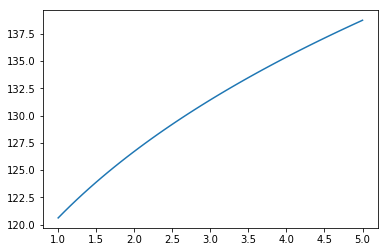

In [44]:
plot(linspace(1, 5), PropsSI('T', 'P', 1e5+linspace(1e5, 5e5), 'Q', 0, 'methane'));

In [36]:
CPCH4 = CoolProp(species = ['methane'])
res = orifice_flow(CPCH4, T1 = 150, P1 = 401325)
res.rho*res.v*pi/4*.001**2*1e3

0.7821542090306909

H<sub>2</sub> + $\frac{\eta}{2}$ (O<sub>2</sub> + 3.76 N<sub>2</sub>) -> $\max(0, 1-\eta)$ H<sub>2</sub> + $\min(1, \eta)$ H<sub>2</sub>O + $\max\left(0, \frac{\eta-1}{2}\right)$ O<sub>2</sub> + $3.76\frac{\eta}{2}$ N<sub>2</sub>'

In [20]:
MW = {'C':12.0107, 'H':1.00794, 'O':15.9994, 'N':14.0067}
MW['O2'], MW['N2'], MW['H2O'], MW['CO2'] = 2*MW['O'], 2*MW['N'], 2*MW['H'] + MW['O'], MW['C'] + MW['O']*2
MW['H2'] = MW['H']*2

In [21]:
1/(1.5+3.76/2)*MW['H2']/(MW['H2']*1/(1.5+3.76/2) +
                                                MW['O2']*0.5/(1.5+3.76/2) + 
                                                MW['N2']*3.76/2/(1.5+3.76/2) )

0.028521031947834195

In [22]:
1*MW['H2']/(MW['H2']*1 + MW['O2']*0.5 + MW['N2']*3.76/2 )

0.028521031947834195

In [23]:
1*MW['H2']/(MW['H2O']*1 + MW['N2']*3.76/2 )

0.028521031947834195

In [24]:
from hc_therm import alkane_Combustion

ImportError: cannot import name alkane_Combustion

In [25]:
from pylab import *
%matplotlib inline
mpl.style.use('default')

In [26]:
H2 = H2_Combustion(Treac=300., numpoints = 100)
H2_2 = alkane_Combustion(Treac = 300)

In [27]:
CH4 = alkane_Combustion(Treac = 300, nC = 1)
CH4._T_combustion(300, CH4.fstoich)

2060.566659917681

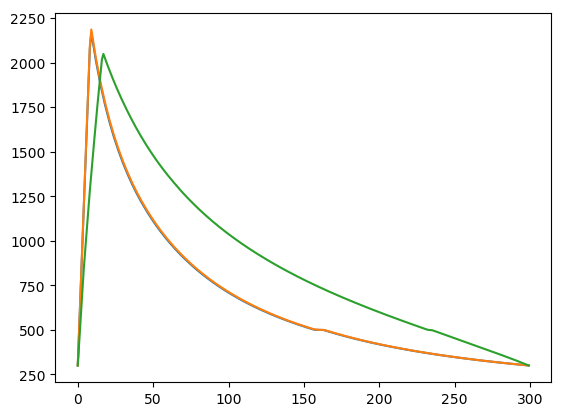

In [28]:
plot(H2.T_prod(np.linspace(0,1, 300)));
plot(H2_2.T_prod(np.linspace(0,1, 300)));
plot(CH4.T_prod(np.linspace(0,1, 300)));

In [29]:
C2H6 = alkane_Combustion(Treac = 300, nC = 2, numpoints = 1000)
C3H8 = alkane_Combustion(Treac = 300, nC = 3)

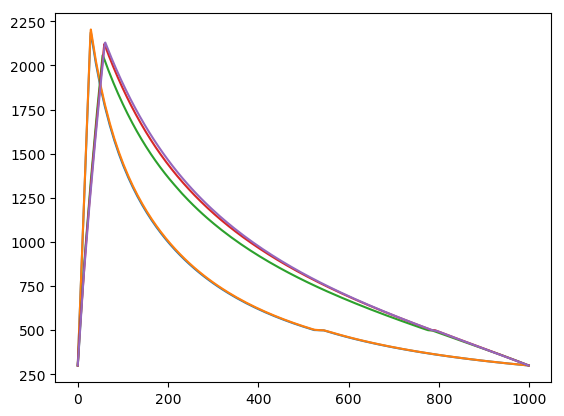

In [30]:
plot(H2.T_prod(np.linspace(0,1, 1000)));
plot(H2_2.T_prod(np.linspace(0,1, 1000))); print H2_2.T_prod(H2_2.fstoich)
plot(CH4.T_prod(np.linspace(0,1, 1000))); print CH4.T_prod(CH4.fstoich)
plot(C2H6.T_prod(np.linspace(0,1, 1000)));print C2H6.T_prod(C2H6.fstoich)
plot(C3H8.T_prod(np.linspace(0,1, 1000)));print C3H8.T_prod(C3H8.fstoich)

In [31]:
from CoolProp.CoolProp import PropsSI

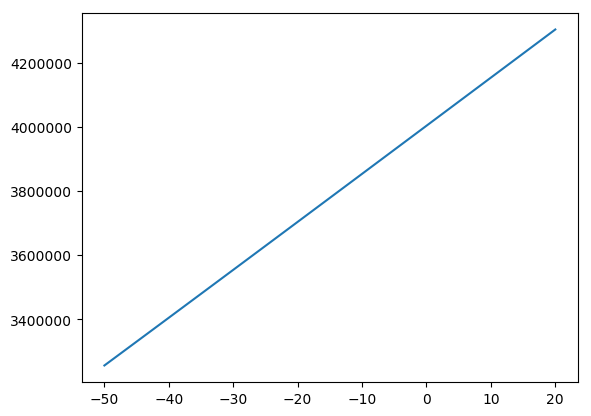

In [32]:
plot(linspace(-50, 20), PropsSI('H', 'T', linspace(-50, 20)+273, 'P', 700e5, 'hydrogen'));

In [33]:
from hc_nn import *
from h2_nn import NotionalNozzle as NNold
from hc_comps import *
from hc_therm import *
from h2_therm import AbelNoble as ANold
from h2_comps import Gas as Gold
from h2_comps import Orifice as Oold

In [34]:
P = 983.2e3
H2 = Gas(CoolProp(), T = 295.4, P = P)
H22 = Gold(ANold(), T = 295.4, P = P)
orifice = Orifice(d=1e-3)
o2 = Oold(d=1e-3)
air = Gas(AbelNoble(b=0, MW = 28.), T = 293, P = 101325.)

In [35]:
NN = NotionalNozzle(H2, orifice, air)
NN2 = NNold(H22, o2, air)

In [36]:
g, o = NN.calculate(T='solve_energy', conserve_momentum = True)
print 'T:', g.T, '\trho:', g.rho, '\tP:', g.P, '\tv:', g.v, '\td:', o.d*1e3
g, o, v = NN2.calculate('YuceilOtugen')
print 'T:', g.T, '\trho:', g.rho, '\tP:', g.P, '\tv:', v, '\td:', o.d*1e3

In [37]:
g, o = NN.calculate(T='T0', conserve_momentum = True)
print 'T:', g.T, '\trho:', g.rho, '\tP:', g.P, '\tv:', g.v, '\td:', o.d*1e3
g, o, v = NN2.calculate('Birch2')
print 'T:', g.T, '\trho:', g.rho, '\tP:', g.P, '\tv:', v, '\td:', o.d*1e3

In [38]:
g, o = NN.calculate(T='Tthroat', conserve_momentum = False)
print 'T:', g.T, '\trho:', g.rho, '\tP:', g.P, '\tv:', g.v, '\td:', o.d*1e3
g, o, v = NN2.calculate('EwanMoodie')
print 'T:', g.T, '\trho:', g.rho, '\tP:', g.P, '\tv:', v, '\td:', o.d*1e3

In [39]:
g, o = NN.calculate(T='T0', conserve_momentum = False)
print 'T:', g.T, '\trho:', g.rho, '\tP:', g.P, '\tv:', g.v, '\td:', o.d*1e3
g, o, v = NN2.calculate('Birch')
print 'T:', g.T, '\trho:', g.rho, '\tP:', g.P, '\tv:', v, '\td:', o.d*1e3

In [40]:
g, o = NN.calculate(T='solve_energy', conserve_momentum = False)
print 'T:', g.T, '\trho:', g.rho, '\tP:', g.P, '\tv:', g.v, '\td:', o.d*1e3
g, o, v = NN2.calculate('Molkov')
print 'T:', g.T, '\trho:', g.rho, '\tP:', g.P, '\tv:', v, '\td:', o.d*1e3

In [41]:
from hc_flame import Flame
sys.stdout = stdout

In [42]:
print(1./80)

In [43]:
fl = Flame(H2, orifice, air, 0, numpts = 500);
fl.solve(Smax = 10*fl.length());

In [104]:
%pylab inline
sys.stdout = stdout

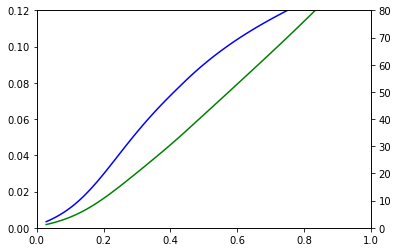

In [45]:
H2_TNF = Gas(AbelNoble(), T = 295.4, P = 101325., v = 10000*89.6e-7/(.08078*3.75e-3))
o_TNF = Orifice(d=3.75e-3)
Q = pi/4.*(o_TNF.d)**2*H2_TNF.v
fl_TNF = Flame(H2_TNF, o_TNF, air, 0, Q = Q, theta0 = pi/2., lamf = 1.24, lamv = 1.24)
fl_TNF.solve();
plot(fl_TNF.y/fl_TNF.length(), 1./fl_TNF.V_cl, 'b');
ylim(0, .12);
twinx()
plot(fl_TNF.y/fl_TNF.length(), 1/fl_TNF.f_cl, 'g');
ylim(0, 80);
xlim(0,1);

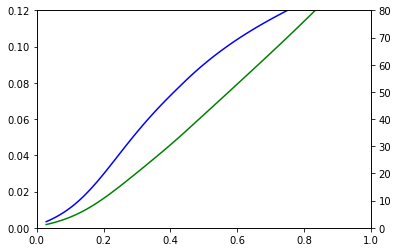

In [46]:
plot(fl_TNF.y/fl_TNF.length(), 1./fl_TNF.V_cl, 'b');
ylim(0, .12);
twinx()
plot(fl_TNF.y/fl_TNF.length(), 1/fl_TNF.f_cl, 'g');
ylim(0, 80);
xlim(0,1);

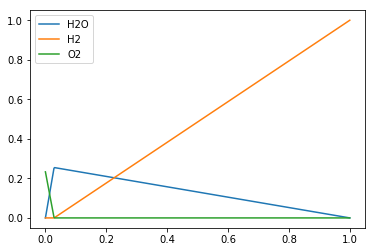

In [47]:
f = linspace(0,1,500)
Yprod = fl.chem._Yprod(f)
plot(f, Yprod['H2O'], label = 'H2O')
plot(f, Yprod['H2'], label = 'H2')
plot(f, Yprod['O2'], label = 'O2')
legend();

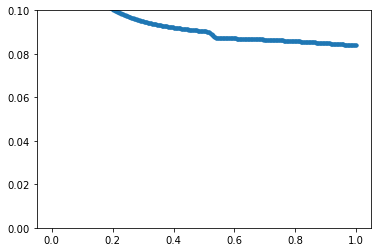

In [48]:
plot(f, fl.chem.rho_prod(f), '.');
ylim(0, .1);

(-1, 0)

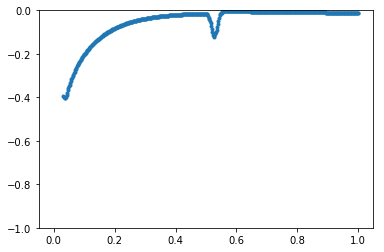

In [49]:
plot(f, fl.chem.drhodf(f), '.');
ylim(-1, 0)

In [50]:
a = {'a': 10., 'b': 5.}
for k in a.keys(): a[k] /= sum(a.values())
a

{'a': 0.66666666666666663, 'b': 0.88235294117647056}

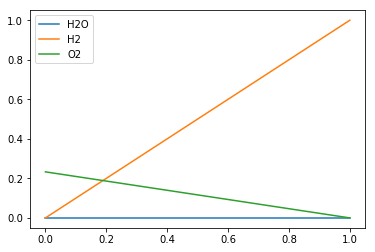

In [51]:
f = linspace(0,1,500)
Yreac = fl.chem._Yreac(f)
plot(f, Yreac['H2O'], label = 'H2O')
plot(f, Yreac['H2'], label = 'H2')
plot(f, Yreac['O2'], label = 'O2')
legend();

In [52]:
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
mpl.rcParams['image.cmap'] = 'jet'
mpl.rcParams['savefig.dpi']=300

In [53]:
a = {'a':'a', 'b':'b', 'c':'c'}
print a
b = a.pop('b')
print b, a

In [54]:
'd' in a.keys()

False

In [55]:
b

'b'

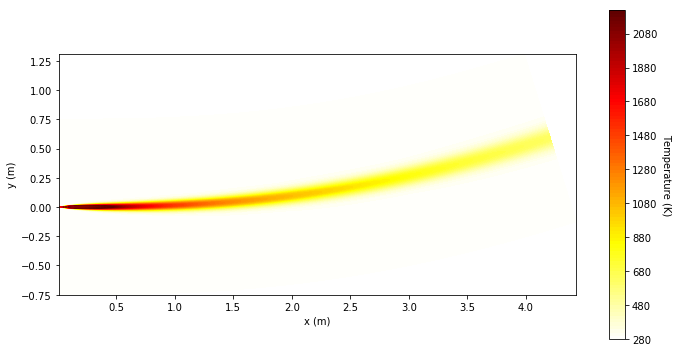

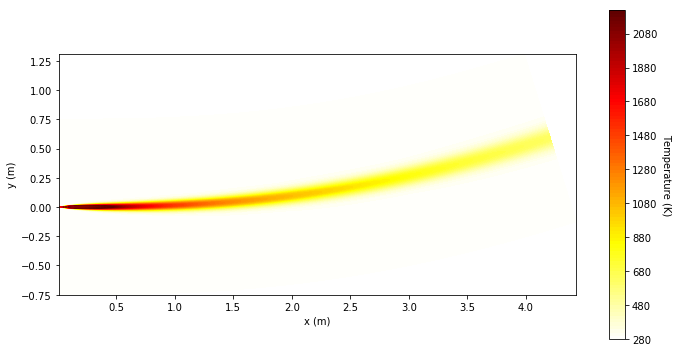

In [56]:
figure(figsize= (10,5))
fl.plot_Ts(cp_params = {'cmap':'hot_r', 'vmax':2500})

In [60]:
H2_Barilo = Gas(AbelNoble(), T = 295.4, P = 1.e4*6894.76)
o_2mm = Orifice(d=2.e-3)
fl_Barilo = Flame(H2_Barilo, o_2mm, air, 0, lamf = 1.24, lamv = 1.24, theta0 = pi/2.)
fl_Barilo.solve(Smax = 10*fl_Barilo.length());

In [61]:
rcParams['savefig.dpi'] = 300

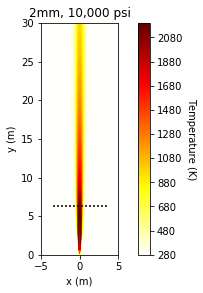

In [67]:
fl_Barilo.plot_Ts(cp_params={'cmap':'hot_r', 'vmax':2500})
title('2mm, 10,000 psi');
ivis = argmin(abs(fl_Barilo.S - fl_Barilo.length()))
r = array([-5*max(fl_Barilo.B), 5*max(fl_Barilo.B)])
plot(fl_Barilo.x[ivis] - r*sin(fl_Barilo.theta[ivis]), fl_Barilo.y[ivis] + r*cos(fl_Barilo.theta[ivis]), 
     dashes = (1,1), color = 'k');
#xlim(0,40); ylim(-5, 20);
ylim(0, 30);xlim(-5,5);

In [70]:
o_4mm = Orifice(d=4.e-3)
fl_Barilo4 = Flame(H2_Barilo, o_4mm, air, 0, lamf = 1.24, lamv = 1.24, theta0 = pi/2.)
fl_Barilo4.solve(Smax = 10*fl_Barilo4.length());

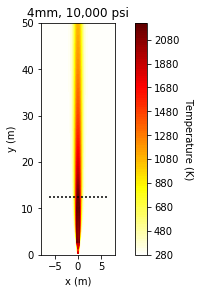

In [75]:
fl_Barilo4.plot_Ts(cp_params={'cmap':'hot_r', 'vmax':2500})
title('4mm, 10,000 psi');
ivis = argmin(abs(fl_Barilo4.S - fl_Barilo4.length()))
r = array([-5*max(fl_Barilo4.B), 5*max(fl_Barilo4.B)])
plot(fl_Barilo4.x[ivis] - r*sin(fl_Barilo4.theta[ivis]), fl_Barilo4.y[ivis] + r*cos(fl_Barilo4.theta[ivis]), 
     dashes = (1,1), color = 'k');
#xlim(0,50); ylim(-10, 40);
xlim(-8, 8), ylim(0, 50);

In [82]:
x, y, Tvals = fl_Barilo4._contourdata()

ImportError: No module named xlwt

In [86]:
savetxt(r'c:/users/ehecht/desktop/x.csv', x, delimiter = ',')
savetxt(r'c:/users/ehecht/desktop/y.csv', y, delimiter = ',')
savetxt(r'c:/users/ehecht/desktop/T.csv', Tvals, delimiter = ',')